## Speech Recognition

A survey of statistical and deep learning models

## Workshop Setup

This lesson requires an Ubuntu Linux environment for the Deepspeech workshop, including downloading the pre-trained model.

Please follow instructions [here](speech.ipynb##Deep-Speech-Workshop-Setup), so that you can run your download in the background.

## Automatic Speech Recognition Pipeline

<img src='assets/speech/asr-pipeline.jpg'/>


Source: https://www.techrepublic.com/article/how-we-learned-to-talk-to-computers/

## Terminology

Phoneme: basic unit of sound (e.g. /e/ in 'pet')

Grapheme: letter(s) that represent phonemes (e.g. sh, ng)

Acoustic model: maps audio signals to phonetic units (phonemes or graphemes)

Language model: maps phonetic units to word sequences

Utterance: spoken input (word, phrase, sentences)

Speaker-dependent speech recognition: recognizes only users it is trained for. Usually large vocabulary but few speakers.

Speaker-independent speech recognition: recognizes multiple users without training. Usually small vocabulary.

## Word Error Rate

$WER = \frac{S + D + I}{N}$

- substitution word count: $S$
- deletion word count: $D$
- insertion word count: $I$
- correct word count: $C$
- number of reference words: $N = S + D + C$

Sometimes called the "Length Normalized Edit Distance"

## Word Accuracy
$WAcc = 1 - WER = \frac{(N - S - D) - I}{N} = \frac{C - I}{N}$

## Speech Feature Extraction

<img src='assets/speech/Spectrogram-19thC.png'/>

A spectrogram for "nineteen century" - power vs. frequency

Common method: Mel-frequency cepstral coefficients (MFCC)

## Statistical Speech Recognition

$$W^* = \underset{W}{\operatorname{argmax}}P(W \mid X)$$

- word sequence: $W$
- most likely word sequence: $W^*$
- acoustic input feature vector (e.g. MFCC): $X$

## Statistical Speech Recognition

After Bayes' Theorem:

$$W^* = \underset{W}{\operatorname{argmax}}p(X \mid W)P(W)$$

- acoustic model: $p(X \mid W)$
- language model (e.g. N-gram): $P(W)$

## Statistical Acoustic Model: $p(X|W)$

<img src='assets/speech/acoustic-statistical.png' width='50%'/>

Credits: https://www.inf.ed.ac.uk/teaching/courses/asr/2016-17/asr03-hmmgmm-handout.pdf

## Hidden Markov Model: $p(S_i \mid S_{i-1})$, Gaussian Mixture Model: $p(X \mid S_i)$

<img src='assets/speech/acoustic-hmm-gmm.png' width='50%'/>

Credits: https://www.inf.ed.ac.uk/teaching/courses/asr/2016-17/asr03-hmmgmm-handout.pdf

## Gaussian Mixture Model

Mixture distribution: combine multiple probabability distributions to make an improved model

$$P(x) = \sum_iP(c=i)P(x \mid c=i)$$

$i^{th}$ Gaussian component: $P(x \mid c=i)$

Applications
- Clustering
- Classification

Nice intro:
https://yulearning.blogspot.sg/2014/11/einsteins-most-famous-equation-is-emc2.html

## Workshop: GMM gender detector
---

Credits: https://github.com/abhijeet3922/PyGender-Voice

<img src='assets/speech/workshop1_pygender.png' style='float:right'/>

1. Download data from [here](
https://www.dropbox.com/s/hcku4t7alrhacqv/pygender.zip?dl=0)

2. Extract the .zip file to a folder of your choice. Note down the path as you will need to enter it in the workshop code.

In [ ]:
# !pip3 install python_speech_features

import os
from os.path import basename, join
import numpy as np

from python_speech_features import mfcc
from scipy.io.wavfile import read
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

TRAIN_PATH = 'C:\\mldds\\pygender\\train_data\\youtube\\' # modify to your actual path

In [ ]:
def get_MFCC(audio_file, scale=True):
    """Computes the Mel-frequency ceptrum coefficients for an audio file
    Args:
        audio_file: input audio file
        scale: whether to scale the features between 0-1
    Returns:
        the MFCC features
    """    
    sample_rate, audio = read(audio_file)
    features = mfcc(audio, sample_rate, winlen=0.025, winstep=0.01,
                    numcep=13, appendEnergy=False)
    if scale:
        features = preprocessing.scale(features) # scale to (0, 1)
    return features

In [ ]:
# Playback a sample file
from IPython import display

sample_file = join(TRAIN_PATH, 'male', 'male1.wav')
sample_rate, audio = read(sample_file)
display.Audio(data=audio, rate=sample_rate)

In [ ]:
# Plot the MFCC
import matplotlib.pyplot as plt

mfcc_vector = get_MFCC(sample_file, scale=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(mfcc_vector), interpolation='nearest',
                 aspect='auto', cmap='coolwarm', origin='lower')
fig.colorbar(cax)
plt.title("Spectrogram of {}".format(sample_file))
plt.show()

In [ ]:
def train_GMM(data_path, n_components=8, covariance_type='diag'):
    """Trains a Gaussian mixture model
    Args:
        data_path: data folder path
        n_components: number of Gaussian components
        covariance_type: type of covariance matrix
    Returns:
        the GMM model
    """    
    files = [join(data_path, f) for f in os.listdir(data_path) if f.endswith('.wav')]
    features = np.asarray(());

    for f in files:
        mfcc_vector = get_MFCC(f)

        if features.size:
            features = np.vstack((features, mfcc_vector))
        else:
            features = mfcc_vector

    gmm = GaussianMixture(n_components=n_components,
                          covariance_type=covariance_type,
                          max_iter=200, n_init=3)
    gmm.fit(features)
    
    # print some metrics applicable to GMMs
    print('BIC: ', gmm.bic(features), ', AIC: ', gmm.aic(features))
    return gmm

In [ ]:
models = dict()
%time models['male'] = train_GMM(join(TRAIN_PATH, 'male'), n_components=8, \
                                 covariance_type='diag')

# ==================================================================
# Exercise:
# Add code below to train the female model, using the above as an example








# ==================================================================
# Optional Exercises:
# a. Try different values of n_component (e.g. 2, 16)
# b. Try different values of covariance_type (e.g. full)
#
# See http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
# on how to interpret the BIC and AIC metrics for selecting models









In [ ]:
def test_GMM(models, test_data_path):
    """Trains a Gaussian mixture model
    Args:
        models: {name: gmm} dictionary of models
        test_data_path: test data folder path
    Returns:
        the predictions
    """    
    files = [os.path.join(test_data_path,f) for f in os.listdir(test_data_path)
             if f.endswith(".wav")]
    
    predictions = []
    for f in files:
        features = get_MFCC(f)
        keys = []
        log_likelihood = np.zeros(len(models))

        for i, (key, gmm) in enumerate(models.items()):
            scores = np.array(gmm.score(features))
            keys.append(key)
            log_likelihood[i] = scores.sum()

        # find the model with the maximum score
        winner = np.argmax(log_likelihood)
        # print('prediction:', keys[winner], "\tscores:", log_likelihood[winner])
        predictions.append(keys[winner])
    return predictions

In [ ]:
# ==================================================================
# Exercise:
# 1. Complete the code below to test the GMM models using test_GMM().
#    Be sure to run against both male and female models.
# 2. Plot the confusion matrix

from sklearn.metrics import confusion_matrix

TEST_PATH = 'C:\\mldds\\pygender\\test_data\\AudioSet' # modify to your actual path










## Shortcomings of Statistical Approaches

Lots of hand-tuning

Inefficient for approximating non-linear data: combination covariance matrices get very large / complicated

Solution: deep learning

## Deep Belief Nets

[Paper](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/38131.pdf)

- Replaces the Gaussian Mixture Model in an ASR system 
- Generative pre-training
 - Speeds up training with less overfitting
 - Train a hidden layer (using Restricted Boltmann Machines or Gaussian RBM)
 - Use the weights as inputs to train next layer
 - Stack up into a forward-only "Deep Belief Net" (DBN)
 - Add softmax to create the DBM-DNN

Python: https://pypi.org/project/nolearn/

![DBN-DNN](assets/speech/dbn-dnn.png)

![DBN-DNN performance](assets/speech/dbn-dnn-compare.png)

## Recurrent Neural Networks

[Paper](http://proceedings.mlr.press/v32/graves14.pdf)

End-to-End Speech Recognition
- Transcription is hard. Skip it and train model that converts speech directly to text
- Bidirectional LSTM to learn long sequences
- Correctionist Temporal Classification (CTC) to align audio with text 

## LSTM

- Learns long sequences (like speech)
- Forget gate learns what to forget

![lstm](assets/speech/lstm.png)

## Birectional Recurrent Layer

![BRNN](assets/speech/brnn.png)

- Forward
$$\overrightarrow{h}^l_t = g(h^{l-1}_t, \overrightarrow{h}^l_{t-1})$$
- Backward
$$\overleftarrow{h}^l_t = g(h^{l-1}_t, \overleftarrow{h}^l_{t+1})$$
- $g(.)$ can be recurrent, GRU, LSTM
- Learns context in both directions (like words in speech)

## Correctionist Temporal Classification

https://www.cs.toronto.edu/~graves/icml_2006.pdf

- Goal: a temporal classifier that can classify unseen audio input sequences with low error rate
- To train speech to text, we need to know how audio "lines up" with transcripts
- Input sequences: $X$ (such as audio)
- Output sequences: $Y$ (such as transcripts)
- Error rate: normalized edit distance between predicted and target labels 

Problem: $X$ and $Y$ can vary in length, in different ways
![CTC](assets/speech/naive_alignment.svg)

Solution: introduce the blank token ($\epsilon$)
![CTC](assets/speech/ctc_alignment_steps.svg)

Process: train an RNN to estimate probabilities of each character per time step

## CTC implementation

- Recurrent neural network, e.g. bidirectional LSTM
- CTC loss function, maximize log likelihood
- Decoding: prefix search instead of best path search

![CTC](assets/speech/full_collapse_from_audio.svg)

[Visual Guide and Explanation](https://distill.pub/2017/ctc/)

## Walkthrough: Correctionist Temporal Classification
---
Credits: https://github.com/igormq/ctc_tensorflow_example

In [ ]:
"""This is a simple example that illustrates how CTC is computed from TensorFlow
For brevity, it only supports 1 training input and 1 validation input
For an example of batched input, use:
https://github.com/philipperemy/tensorflow-ctc-speech-recognition
"""

# !pip3 install jupyter-tensorboard

import os
import sys
import numpy as np
from os.path import join
from python_speech_features import mfcc
from scipy.io.wavfile import read
from sklearn import preprocessing
import tensorflow as tf
import time

# Constants
SPACE_TOKEN = '<space>'
SPACE_INDEX = 0
FIRST_INDEX = ord('a') - 1  # 0 is reserved to space

# Configuration
num_features = 13
num_units = 50 # Number of units in the LSTM cell

# Number of classes: 'a' to 'z' +  space + blank label = 28 characters
num_classes = ord('z') - ord('a') + 1 + 1 + 1

# Hyper-parameters
num_epochs = 200
num_hidden = 50
# Get training and validation inputs
num_layers = 1
batch_size = 1
initial_learning_rate = 1e-2
momentum = 0.9

In [ ]:
# Get training and validation inputs
# Validation input is just the training audio shifted randomly

def process_audio(audio_file, do_random_shift=None):
    """Extracts the MFCC features from an audio file.
    Args:
        audio_file: file containing the input audio
        do_random_shift: whether to randomly shift the audio
                      (e.g. for generating test inputs)
    Returns:
        A tuple with (features, sequence length)
    """
    sample_rate, audio = read(audio_file)

    if do_random_shift:
        random_shift = np.random.randint(low=1, high=1000)
        print('random_shift =', random_shift)
        truncated_audio = audio[random_shift:]
        
    features = mfcc(audio, sample_rate)
    features = preprocessing.scale(features) # scale to (0, 1)

    features = np.asarray(features[np.newaxis, :])
    features_seq_len = [features.shape[1]]
    return features, features_seq_len

# audio_file = join('files', 'CTC', 'LDC93S1.wav')
audio_file = join('files', 'CTC', '61-70968-0002.wav')

train_input, train_seq_len = process_audio(audio_file)
val_input, val_seq_len = process_audio(audio_file, do_random_shift=True)

In [ ]:
def sparse_tuple_from(sequences, dtype=np.int32):
    """Create a sparse representation of sequences.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n]*len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)

    return indices, values, shape

def process_targets(text_file):
    """Extracts the CTC tokens from an input text file.
    Args:
        text_file: file containing the input text
    Returns:
        A nested tuple with (original text, (indices, CTC tokens, shape))
    """
    with open(text_file, 'r') as f:
        line = f.readlines()[-1] # take the last line

        # Get only the words between [a-z], replace period for none
        original = ' '.join(line.strip().lower().split(' ')).replace('.', '')
        targets = original.replace(' ', '  ')
        targets = targets.split(' ')

    # Add blank label
    targets = np.hstack([SPACE_TOKEN if x == '' else list(x) for x in targets])

    # Transform char into index
    targets = np.asarray([SPACE_INDEX if x == SPACE_TOKEN else ord(x) - FIRST_INDEX
                          for x in targets])

    # Creat sparse representation to feed into the graph
    return original, sparse_tuple_from([targets])

# Generate training and validation targets
# target = join('files', 'CTC', 'LDC93S1.txt')
target = join('files', 'CTC', '61-70968-0002.txt')
train_original, train_targets = process_targets(target)
val_original, val_targets = train_original, train_targets

In [ ]:
"""Builds a CTC graph for speech recognition, using
one or more LSTM cells with a CTC loss function.
"""
graph = tf.Graph()
with graph.as_default():
    # e.g: log filter bank or MFCC features
    # Has size [batch_size, max_stepsize, num_features], but the
    # batch_size and max_stepsize can vary along each step
    inputs = tf.placeholder(tf.float32, [None, None, num_features])

    # Here we use sparse_placeholder that will generate a
    # SparseTensor required by ctc_loss op.
    targets = tf.sparse_placeholder(tf.int32)

    # 1d array of size [batch_size]
    seq_len = tf.placeholder(tf.int32, [None])

    # Defining the cell
    # Can be:
    #   tf.nn.rnn_cell.RNNCell
    #   tf.nn.rnn_cell.GRUCell 
    cells = []
    for _ in range(num_layers):
        cell = tf.contrib.rnn.LSTMCell(num_units)
        cells.append(cell)
    stack = tf.contrib.rnn.MultiRNNCell(cells)

    # The second output is the last state and we will not use that
    outputs, _ = tf.nn.dynamic_rnn(stack, inputs, seq_len, dtype=tf.float32)

    shape = tf.shape(inputs)
    batch_s, max_timesteps = shape[0], shape[1]

    # Reshaping to apply the same weights over the timesteps
    outputs = tf.reshape(outputs, [-1, num_hidden])

    # Truncated normal with mean 0 and stdev=0.1
    W = tf.Variable(tf.truncated_normal([num_hidden,
                                         num_classes],
                                        stddev=0.1))
    # Zero initialization
    b = tf.Variable(tf.constant(0., shape=[num_classes]))

    # Doing the affine projection
    logits = tf.matmul(outputs, W) + b

    # Reshaping back to the original shape
    logits = tf.reshape(logits, [batch_s, -1, num_classes])

    # Time major
    logits = tf.transpose(logits, (1, 0, 2))

    loss = tf.nn.ctc_loss(targets, logits, seq_len)
    cost = tf.reduce_mean(loss)

    optimizer = tf.train.MomentumOptimizer(initial_learning_rate,
                                           0.9).minimize(cost)

    # Option 2: tf.nn.ctc_beam_search_decoder
    # (it's slower but you'll get better results)
    decoded, log_prob = tf.nn.ctc_greedy_decoder(logits, seq_len)

    # Inaccuracy: label error rate
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded[0], tf.int32),
                                          targets))
    
    # TensorBoard summary operation
    tf.summary.scalar('ctc_cost', cost)
    tf.summary.scalar('label_error_rate', ler)
    summary_op = tf.summary.merge_all()

In [ ]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()

    log_index = int(time.time())
    train_summary_writer = tf.summary.FileWriter('./logs/ctc/{}/train'.format(log_index), session.graph)
    val_summary_writer = tf.summary.FileWriter('./logs/ctc/{}/val'.format(log_index), session.graph)

    # Repeat for num_epochs
    for curr_epoch in range(num_epochs):
        start = time.time()

        feed = {inputs: train_input,
                targets: train_targets,
                seq_len: train_seq_len}

        train_cost, train_ler, _, summary = session.run([cost, ler, optimizer, summary_op], feed_dict=feed)
        train_summary_writer.add_summary(summary, curr_epoch)

        val_feed = {inputs: val_input,
                    targets: val_targets,
                    seq_len: val_seq_len}

        val_cost, val_ler, val_summary = session.run([cost, ler, summary_op], feed_dict=val_feed)
        val_summary_writer.add_summary(val_summary, curr_epoch)
        
        log = "Epoch {}/{}, train_cost = {:.3f}, train_ler = {:.3f}, val_cost = {:.3f}, val_ler = {:.3f}, time = {:.3f}"
        print(log.format(curr_epoch+1, num_epochs, train_cost, train_ler,
                         val_cost, val_ler, time.time() - start))
    # Decoding
    d = session.run(decoded[0], feed_dict=val_feed)
    str_decoded = ''.join([chr(x) for x in np.asarray(d[1]) + FIRST_INDEX])

    # Replacing blank label to none
    str_decoded = str_decoded.replace(chr(ord('z') + 1), '')

    # Replacing space label to space
    str_decoded = str_decoded.replace(chr(ord('a') - 1), ' ')

    print('Original:\n%s' % val_original)
    print('Decoded:\n%s' % str_decoded)

## Deep Speech

- Deep Speech: https://arxiv.org/pdf/1412.5567.pdf
- Deep Speech 2: https://arxiv.org/pdf/1512.02595.pdf

## DS1 Architecture

<img src='assets/speech/deepspeech-arch.png' style='float:right;'/>

RNN: 3 non-recurrent and 1 bi-directional recurrent layer, 1 non-recurrent
- Input: spectrogram
- Output: sequence of _character_ probabilities
- Decoding: 5-gram language model
- Loss function: CTC
- Nesterov's Accelerated Gradient Descent ([evolution of gradient descent](https://medium.com/@ramrajchandradevan/the-evolution-of-gradient-descend-optimization-algorithm-4106a6702d39))

## Decoding with Language Model

Reduce WER by including language model:

$\underset{y}{\operatorname{argmax}}Q(y) = log(p_ctc(y \mid x)) + \alpha * log(p_lm(y)) + \beta * 
word\_count(y)$
- $\alpha$: relative weight of language model vs. CTC
- $\beta$: considers more words

Beam search: take $k$ best $y$ on every iteration, similar to breath-first-search but with beam width $k$

![decoding](assets/speech/deepspeech-decoding.png)

## Dataset Construction

- Synthesize noisy speech by overlaying tracks
- Lombard Effect: play loud background noise while recording so that speaker will raise their pitch

## Performance

![performance](assets/speech/deepspeech-performance.png)


Dataset: https://catalog.ldc.upenn.edu/LDC2002S23

## DeepSpeech 2

- Same model recognizes multiple languages (English or Mandarin Chinese)
   - no separate pronounciation model needed
- Parellel GPU training optimizations cut down training & iteration times
   - GPU implementation of CTC
   - custom memory allocators

## DS2 Architecture

<img src='assets/speech/deepspeech2-arch.png' style='float:right;' width='50%'/>
- More layers (recurrent, convolutional)
- Batch Normalization
- SortaGrad learning strategy

## Batch Normalization

- Original paper: https://arxiv.org/abs/1502.03167

$$B(x) = \gamma \frac{x - Mean[x]}{(Variance[x] + \epsilon)^\frac{1}{2}} + \beta $$

- $Mean[x]$, $Variance[x]$: Minibatch mean and variance
- $\gamma$, $\beta$: learned parameters
- $\epsilon$: small constant to avoid division by zero
- Typically applied before activation $f(x)$:
$$h^l = f(B(W^lh^{l-1}))$$
- For bidirectional RNNs, Batch Norm is applied sequence-wise:
$$h^l_t = f(B(W^lh^{l-1}) + U^lh^l_{t-1})$$

## Batch Normalization Effect

- Generally: speeds up convergence by removing "uninteresting" changes in mean and variance ("internal covariate shift")
- Deep Speech 2: improved generalization error by as much as 12%

<img src='assets/speech/deepspeech2-batchnorm.png'/>

## SortaGrad (Curriculum Strategy)

- Longer utterances usually have higher CTC cost than shorter utterances
  - Early in training: susceptible to numerical instabilities like underflow, exploding gradient    
- Solution
  - During the first epoch, sort utterances so that shorter utterances are encountered first
  - Subsequent epochs: revert to random order

<img src='assets/speech/deepspeech2-sortagrad.png'/>

## Decoding

Fuse acoustic model with language model:

$$Q(y) = log(p_ctc(y \mid x)) + \alpha * log(p_lm(y)) + \beta * 
word\_count(y)$$
- $\alpha$: relative weight of language model vs. CTC
- $\beta$: considers more words

Language model
- n-gram: scales to large quantities of unlabeled text
- English: 850 million n-grams
- Mandarin: 2 billion n-grams (character level).
   - Output layer is 6000 characters
   - includes English alphabets to handle mixed Chinese-English transcripts

## Dataset Construction

Pipeline
- Birectional RNN with CTC to align transcription to audio
- Segmentation: splice audio between long silences, average 7s length
- Linear classifier to predict bad examples from failed alignments, using crowd sourced ground truth transcriptions

Data augmentation by adding noise to 40% of random utterances
- too much noise makes optimization difficult
- too little noise makes system less robust to noisy speech

## Performance

![performance](assets/speech/deepspeech2-perf.png)

## Implementations

Deep Speech 1
- https://github.com/mozilla/DeepSpeech

Deep Speech 2
- https://github.com/NervanaSystems/deepspeech
- https://github.com/yao-matrix/deepSpeech2

## Datasets

- [CHiME](http://spandh.dcs.shef.ac.uk/chime_challenge/index.html)
- [Mozilla Common Voice](https://voice.mozilla.org/en/data)
- [VoxForge](http://www.voxforge.org)
- [AudioSet](https://research.google.com/audioset/)

## Workshop: Deep Speech
---
https://github.com/mozilla/DeepSpeech

|Environment|GPU (Required, Recommended, None)|
|--|--|
|Ubuntu|Recommended|

## Deep Speech Workshop Setup

DeepSpeech requires Ubuntu, run the following commands from an Ubuntu machine.

```
conda create --name deepspeech
source activate deepspeech
pip3 install jupyter matplotlib python_speech_features --user

# If running without GPU
pip3 install deepspeech

# If running on GPU
pip3 install deepspeech-gpu

# Download pre-trained models (approx. 1.4GB)
curl -o deepspeech-0.1.1-models.tar.gz -L https://github.com/mozilla/DeepSpeech/releases/download/v0.1.1/deepspeech-0.1.1-models.tar.gz

# Extract
tar -xvzf deepspeech-0.1.1-models.tar.gz

# Install SoX to convert audio to single channel 16kHz PCM
# needed by DeepSpeech
sudo apt-get install -y sox

# Launch Jupyter and browse to this notebook
jupyter notebook
```

In [1]:
# Ref: https://github.com/mozilla/DeepSpeech/blob/master/native_client/python/client.py
from deepspeech.model import Model

import numpy as np
import subprocess

# Model
MODEL_GRAPH = 'models/output_graph.pb'
LANGUAGE_MODEL = 'models/lm.binary'
LM_ALPHABET = 'models/alphabet.txt'
LM_TRIE = 'trie'

## Input Processing

We'll define a helper function `prepare_input` that prepares the input to match the training data characteristics:
- Sample rate of 16kHz
- Duration of 6 seconds

We'll also define another function `visualize_input` that plots the spectrogram of the audio sample.

In [24]:
def prepare_input(audio_path):
    """Ensures audio matches the sample rate supported by Deep Speech,
       and truncates the audio to the required length.
    Args:
        audio_path: path ot the audio file
    Returns:
        A tuple with (sample_rate, converted_audio)    
    """    
    import scipy.io.wavfile as wav
    sample_rate = 16000
    duration_secs = 6

    fs, audio = wav.read(audio_path)
    if fs != sample_rate:
        if fs < sample_rate:
            print('Warning: original sample rate (%d) is lower than 16kHz. Up-sampling might produce erratic speech recognition.' % (fs), file=sys.stderr)
    
        print('Resampling audio from {}kHz to 16kHz'.format(fs/1000))
        sox_cmd = 'sox {} --type raw --bits 16 --channels 1 --rate {} - '.format(audio_path, sample_rate)
        try:
            p = subprocess.Popen(sox_cmd.split(),
                                 stderr=subprocess.PIPE, stdout=subprocess.PIPE)
            output, err = p.communicate()

            if p.returncode:
                raise RuntimeError('SoX returned non-zero status: {}'.format(err))

        except OSError as e:
            raise OSError('SoX not found, use 16kHz files or install it: ', e)

        audio = np.fromstring(output, dtype=np.int16)

    # Truncate to smaller length, as DeepSpeech is trained on
    # short utterances (a few seconds long)
    print('Truncating audio from {}s to {}s'.format(len(audio)/sample_rate, duration_secs))

    max_frames = sample_rate * duration_secs
    audio = audio[:max_frames]
plot_input
    return sample_rate, audio

def visualize_input(sample_rate, audio, title):
    """Plots an audio spectrogram
    Args:
        sample_rate: sample rate
        audio: audio sample buffer
        title: plot title
    """   
    import matplotlib.pyplot as plt
    from python_speech_features import mfcc
    
    features = mfcc(audio, sample_rate, winlen=0.025, winstep=0.01,
                    numcep=13, appendEnergy=False)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
    cax = ax.matshow(np.transpose(features), interpolation='nearest',
                     aspect='auto', cmap='coolwarm', origin='lower')
    fig.colorbar(cax)
    
    plt.title(title)
    plt.show()

## Test input
Just for fun, we'll try a corpus of Singapore English.

You can find examples from the [NIE Corpus of Spoken Singapore English](http://videoweb.nie.edu.sg/phonetic/niecsse/index.htm)

For comparison, you can generate US English samples using an [online text-to-speech generator](https://www.text2speech.org/)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1582k  100 1582k    0     0   9.9M      0 --:--:-- --:--:-- --:--:--  9.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  143k  100  143k    0     0  1215k      0 --:--:-- --:--:-- --:--:-- 1223k
Resampling audio from 22.05kHz to 16kHz
Truncating audio from 36.7333125s to 6s
Truncating audio from 4.58s to 6s


/home/lisaong/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


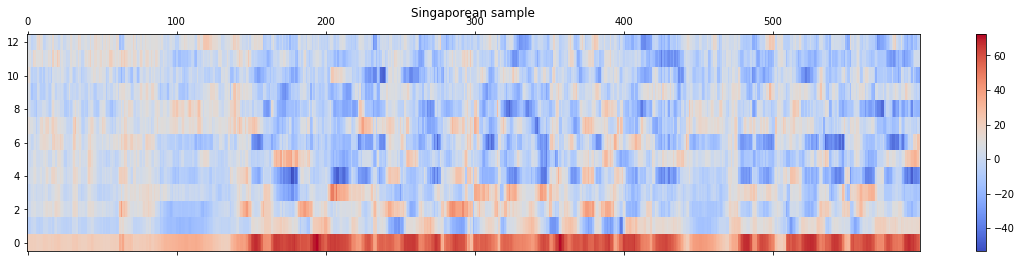

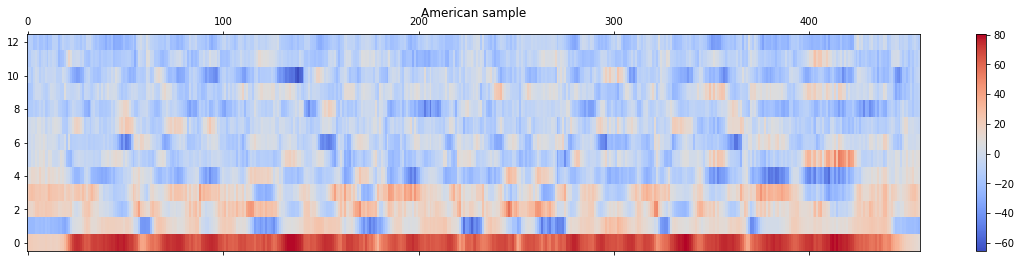

In [26]:
# Try something from the NIE Corpus of Spoken Singapore English
# http://videoweb.nie.edu.sg/phonetic/niecsse/index.htm
transcription = 'The North Wind and the Sun were disputing which was the stronger when a traveler came along'

!curl -o singaporean.wav -L 'http://videoweb.nie.edu.sg/phonetic/niecsse/nws/nws-SE-f1.WAV'
!curl -o american.wav -L 'https://www.text2speech.org/FW/getfile.php?file=968ac1e0b7bf8e5c88ac1887dda35bba%2Fspeech.wav'

sample_rate1, audio1 = prepare_input('singaporean.wav')
sample_rate2, audio2 = prepare_input('american.wav')

visualize_input(sample_rate1, audio1, "Singaporean sample")
visualize_input(sample_rate2, audio2, "American sample")

## Perform the inference
- Load the acoustic model
- Enable language model decoding

In [ ]:
# Constants
# These constants control the beam search decoder
# Beam width used in the CTC decoder when building candidate transcriptions
BEAM_WIDTH = 500

# The alpha hyperparameter of the CTC decoder. Language Model weight
LM_WEIGHT = 1.75

# The beta hyperparameter of the CTC decoder. Word insertion weight (penalty)
WORD_COUNT_WEIGHT = 1.00

# Valid word insertion weight. This is used to lessen the word insertion penalty
# when the inserted word is part of the vocabulary
VALID_WORD_COUNT_WEIGHT = 1.00

# These constants are tied to the shape of the graph used (changing them changes
# the geometry of the first layer), so make sure you use the same constants that
# were used during training

# Number of MFCC features to use
N_FEATURES = 26

# Size of the context window used for producing timesteps in the input vector
N_CONTEXT = 9

# Load the acoustic model
ds = Model(MODEL_GRAPH, N_FEATURES, N_CONTEXT, LM_ALPHABET, BEAM_WIDTH)
print('Loaded model')

# Load the language model
ds.enableDecoderWithLM(LM_ALPHABET, LANGUAGE_MODEL, LM_TRIE, LM_WEIGHT,
                       WORD_COUNT_WEIGHT, VALID_WORD_COUNT_WEIGHT)

print('Loaded language model')

%time result1 = ds.stt(audio1, sample_rate1)
print('Original:', transcription)
print('Singaporean:', result1)

%time result2 = ds.stt(audio2, sample_rate2)
print('American:', result2)

Loaded model
Loaded language model


In [ ]:
## You'll notice that the 

https://discourse.mozilla.org/t/tutorial-how-i-trained-a-specific-french-model-to-control-my-robot/22830